<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177866 entries, 0 to 177865
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         177866 non-null  object 
 1   County                                             177861 non-null  object 
 2   City                                               177861 non-null  object 
 3   State                                              177866 non-null  object 
 4   Postal Code                                        177861 non-null  float64
 5   Model Year                                         177866 non-null  int64  
 6   Make                                               177866 non-null  object 
 7   Model                                              177866 non-null  object 
 8   Electric Vehicle Type                              177866 non-null  object

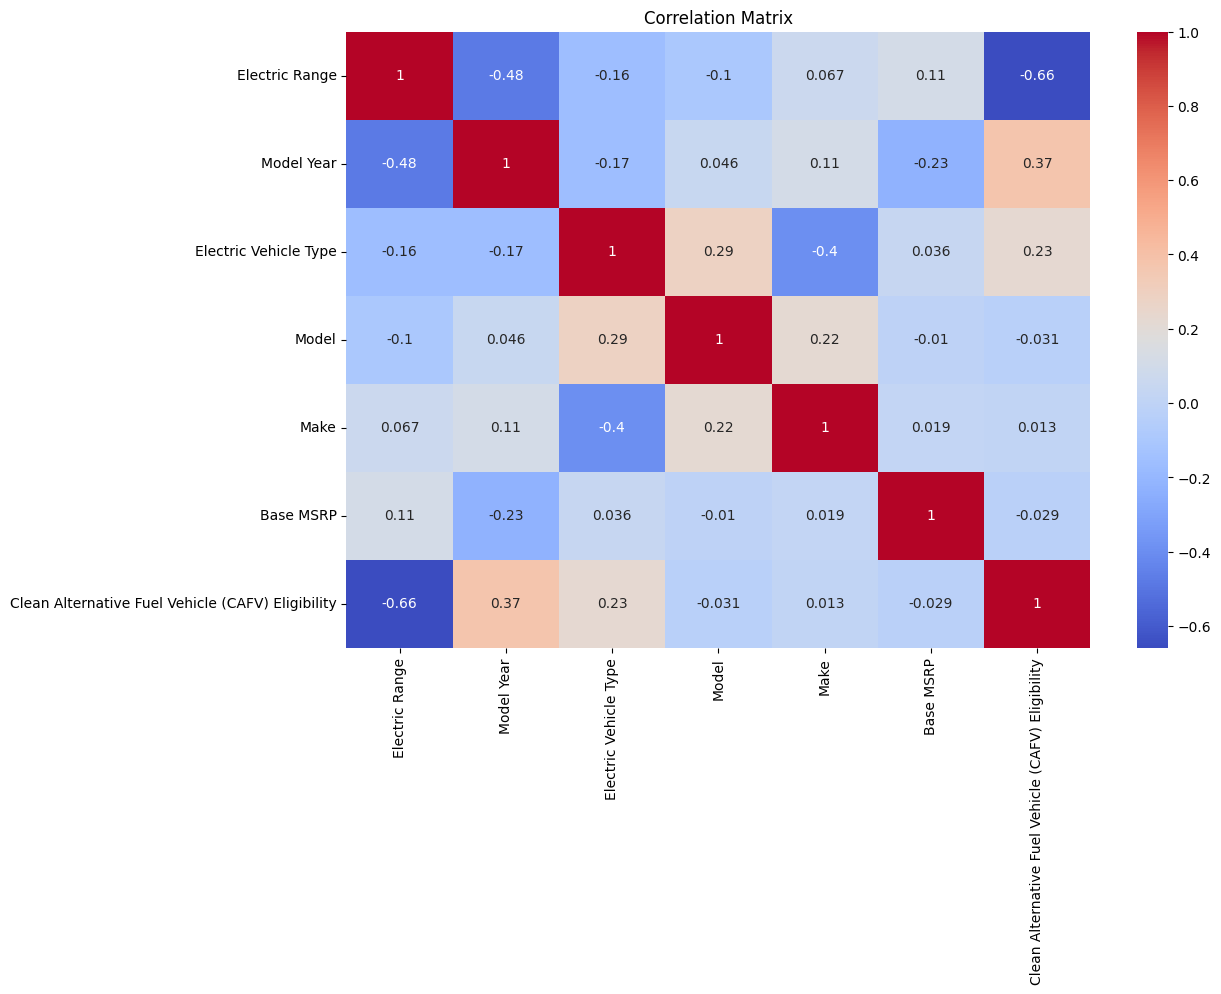

Cross-validation results:
Logistic Regression: 0.9988


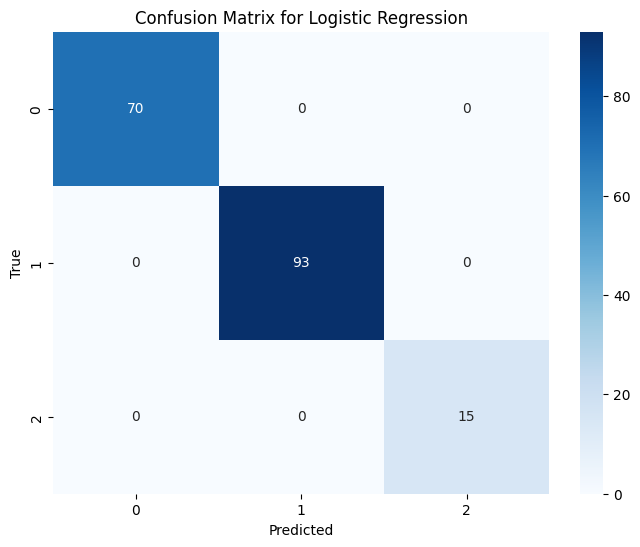

SVM: 0.9981


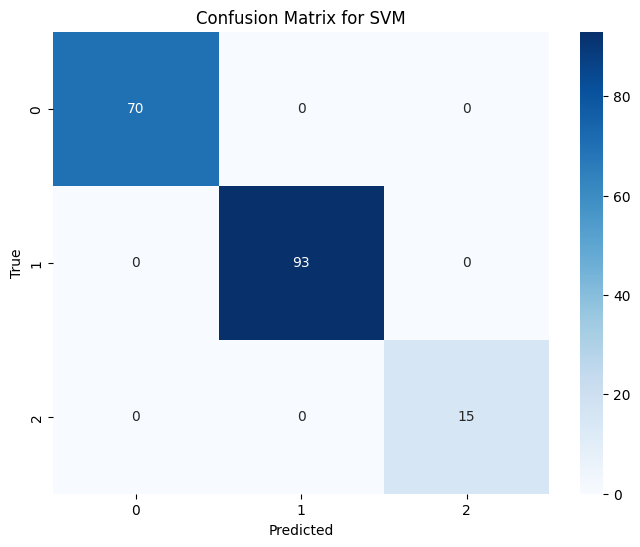

KNN: 0.9975


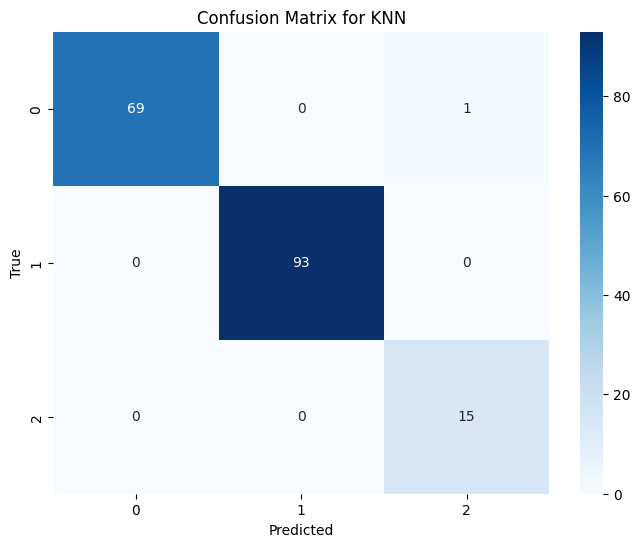

XGBoost: 0.9975


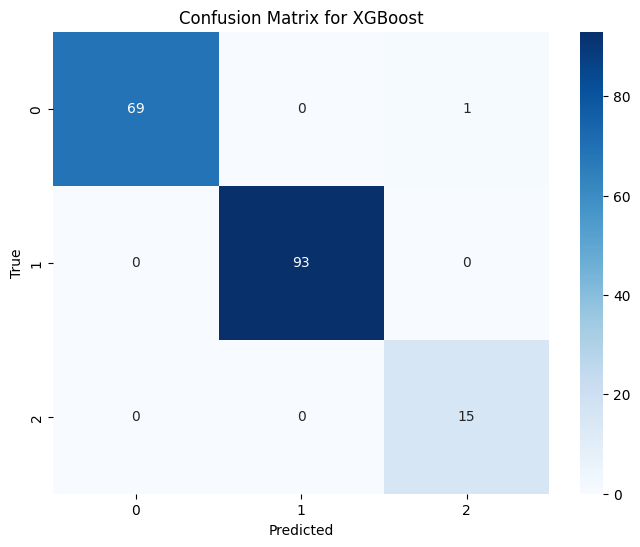

LightGBM: 0.9975


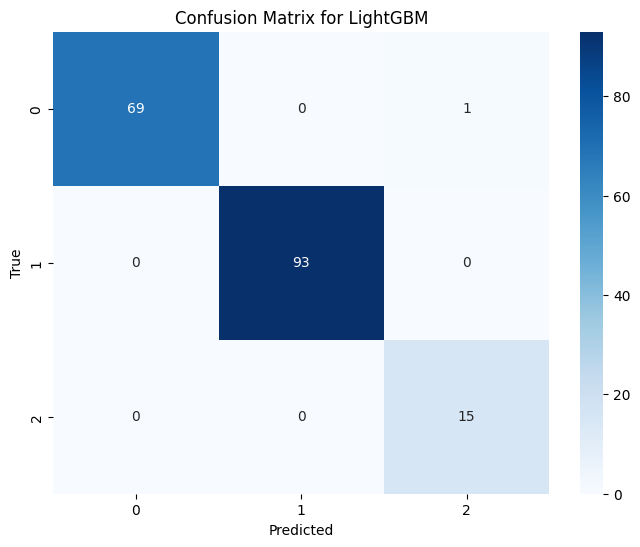


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        15

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report for SVM:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        15

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report

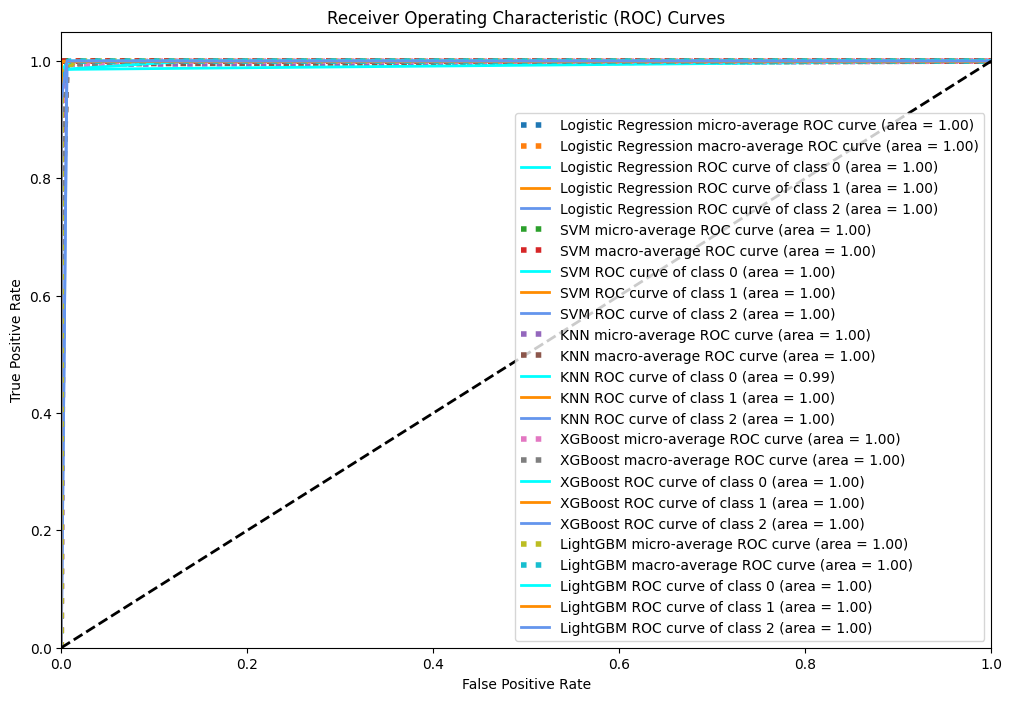

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from joblib import Parallel, delayed
from itertools import cycle
import numpy as np

# Load the dataset
ev_data = pd.read_csv(r"Electric_Vehicle_Population_Data.csv")

# Conduct EDA
print(ev_data.info())
print(ev_data.describe())

# Check for duplicates
duplicates = ev_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Handle missing values
cleaned_data = ev_data.fillna(ev_data.mean(numeric_only=True))
for column in cleaned_data.select_dtypes(include=['object', 'category']).columns:
    cleaned_data[column] = cleaned_data[column].fillna(cleaned_data[column].mode()[0])

# Use Label Encoding to encode categorical columns
columns_to_encode = ['VIN (1-10)', 'County', 'City', 'State', 'Make', 'Model',
                     'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
                     'Vehicle Location', 'Electric Utility']
                     
# Encode categorical columns using LabelEncoder
cleaned_data_encoded = cleaned_data.copy()
label_encoders = {column: LabelEncoder().fit(cleaned_data_encoded[column]) for column in columns_to_encode}
for column, le in label_encoders.items():
    cleaned_data_encoded[column] = le.transform(cleaned_data_encoded[column])

# Select important features based on feature importance analysis
selected_features = [
    'Electric Range', 'Model Year', 'Electric Vehicle Type', 
    'Model', 'Make', 'Base MSRP'
]

# Calculate correlation matrix
correlation_matrix = cleaned_data_encoded[selected_features + ['Clean Alternative Fuel Vehicle (CAFV) Eligibility']].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Use a smaller sample of the data for training
sampled_data = cleaned_data_encoded.sample(frac=0.01, random_state=42)  # Reduced sample size to 1%

# Split the data into features and target
X = sampled_data[selected_features]
y = sampled_data['Clean Alternative Fuel Vehicle (CAFV) Eligibility']

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Re-split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42)

# Feature selection using SelectKBest
selector = SelectKBest(f_classif, k=2)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Define the models with simpler configurations
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),  # Using a linear kernel to reduce complexity
    'KNN': KNeighborsClassifier(n_neighbors=3),  # Reducing the number of neighbors
    'XGBoost': XGBClassifier(max_depth=3, n_estimators=10),  # Further reduced depth and number of estimators
    'LightGBM': LGBMClassifier(max_depth=3, n_estimators=10)  # Further reduced depth and number of estimators
}

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Function to evaluate a model
def evaluate_model(model_name, model, X_train_selected, y_train, X_test_selected, y_test):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_selected, y_train, cv=cv)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_selected)
    else:
        y_pred_proba = model.decision_function(X_test_selected)
        # Convert decision function output to probability
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
    return model_name, scores.mean(), y_pred, y_pred_proba

# Evaluate all models in parallel
results = Parallel(n_jobs=-1)(delayed(evaluate_model)(model_name, model, X_train_selected, y_train, X_test_selected, y_test) for model_name, model in models.items())

# Display cross-validation results and confusion matrices
print("Cross-validation results:")
for model_name, score, y_pred, y_pred_proba in results:
    print(f"{model_name}: {score:.4f}")
    plot_confusion_matrix(y_test, y_pred, model_name)

# Display classification report and other metrics
for model_name, score, y_pred, y_pred_proba in results:
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Plot ROC curves for each model
plt.figure(figsize=(12, 8))

for model_name, score, y_pred, y_pred_proba in results:
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'{model_name} micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'{model_name} macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
             linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{model_name} ROC curve of class {i} (area = {roc_auc[i]:.2f})')

# Plot diagonal reference line and ROC curve with labels and legend
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


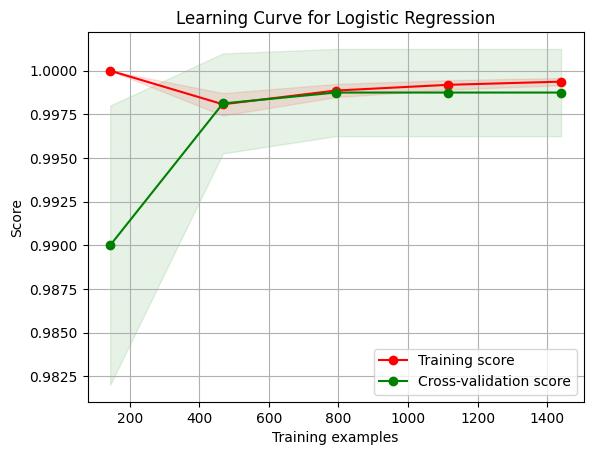

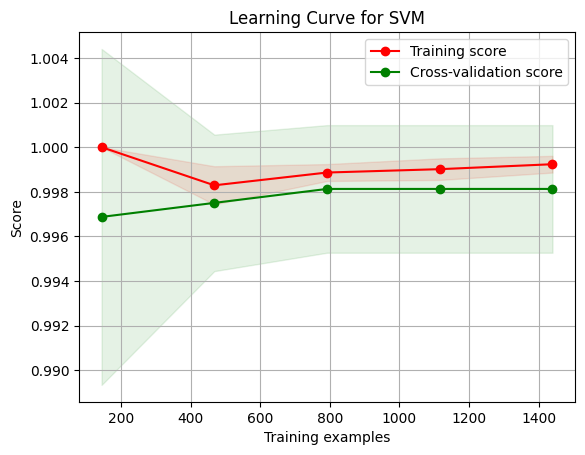

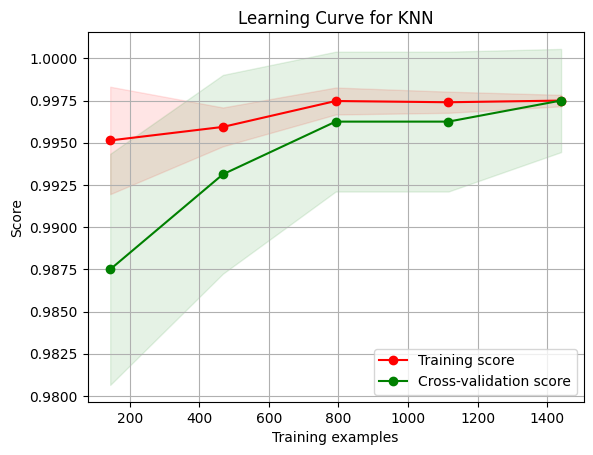

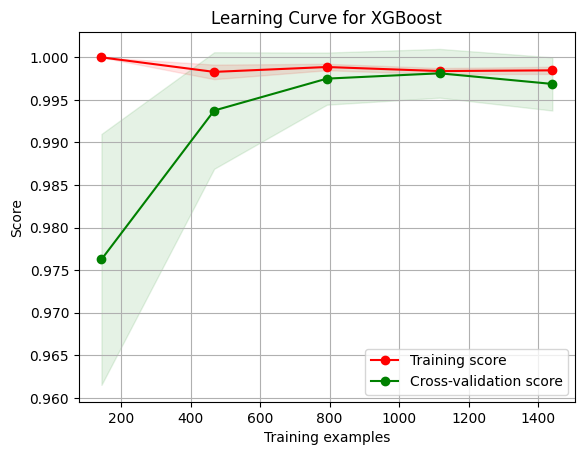

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 2
[LightGBM] [Info] Start training from score -1.037988
[LightGBM] [Info] Start training from score -0.665748
[LightGBM] [Info] Start training from score -2.025374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

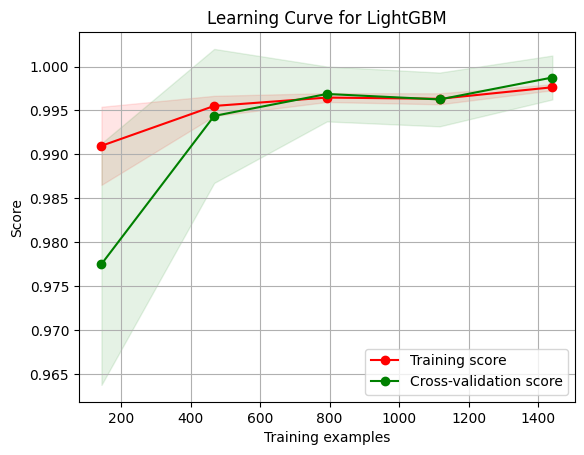

In [2]:
# Define a function to plot the learning curve of an estimator
from sklearn.model_selection import learning_curve
import numpy as np 
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Compute learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # Plot the learning curve
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves for each model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
    plot_learning_curve(model, f"Learning Curve for {model_name}", X_train_selected, y_train, cv=cv)
    plt.show()


In [3]:
# Splitting the data into training and hold-out validation sets
X_train_final, X_holdout, y_train_final, y_holdout = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Evaluate each model on the hold-out validation set
holdout_results = {}
for model_name, model in models.items():
    model.fit(X_train_final, y_train_final)
    y_holdout_pred = model.predict(X_holdout)
    holdout_results[model_name] = {
        "accuracy": accuracy_score(y_holdout, y_holdout_pred),
        "precision": precision_score(y_holdout, y_holdout_pred, average='weighted'),
        "recall": recall_score(y_holdout, y_holdout_pred, average='weighted'),
        "f1_score": f1_score(y_holdout, y_holdout_pred, average='weighted')
    }

# Print hold-out validation set results
print("\nHold-Out Validation Set Results:")
for model_name, metrics in holdout_results.items():
    print(f"\n{model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 2
[LightGBM] [Info] Start training from score -0.993322
[LightGBM] [Info] Start training from score -0.641784
[LightGBM] [Info] Start training from score -2.270090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [4]:
# Train and Test Scores for the final evaluation
final_train_test_results = {}
for model_name, model in models.items():
    model.fit(X_train_final, y_train_final)
    y_train_pred = model.predict(X_train_final)
    y_test_pred = model.predict(X_test_selected)
    final_train_test_results[model_name] = {
        "train_accuracy": accuracy_score(y_train_final, y_train_pred),
        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "train_precision": precision_score(y_train_final, y_train_pred, average='weighted'),
        "test_precision": precision_score(y_test, y_test_pred, average='weighted'),
        "train_recall": recall_score(y_train_final, y_train_pred, average='weighted'),
        "test_recall": recall_score(y_test, y_test_pred, average='weighted'),
        "train_f1_score": f1_score(y_train_final, y_train_pred, average='weighted'),
        "test_f1_score": f1_score(y_test, y_test_pred, average='weighted')
    }

# Print Train and Test Scores
print("\nTrain and Test Scores Comparison:")
for model_name, metrics in final_train_test_results.items():
    print(f"\n{model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 1423, number of used features: 2
[LightGBM] [Info] Start training from score -0.993322
[LightGBM] [Info] Start training from score -0.641784
[LightGBM] [Info] Start training from score -2.270090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur